# $$ Sentiment \ Analysis \ of \ Real-time \ Flipkart \ Product \ Reviews $$


### Data Loading and Analysis

In [3]:
# Import the required Libraries

import pandas as pd
import numpy as np
import re
import emoji

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [4]:
PATH = r"C:\Users\kalag\DS_Intern_Inno\Projects_Data\Sentiment Analysis\reviews_badminton\data.csv"
df = pd.read_csv(PATH)

In [5]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [6]:
df.shape

(8518, 8)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Up Votes,8508.0,0.391396,11.613909,0.0,0.0,0.0,0.0,889.0
Down Votes,8508.0,0.121768,3.248022,0.0,0.0,0.0,0.0,219.0
Ratings,8518.0,4.181028,1.262200,1.0,4.0,5.0,5.0,5.0


### EDA and Data Cleaning

In [9]:
df.tail()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [10]:
df.dropna(thresh=3, inplace=True)
df['Place of Review'].fillna('Unknown', inplace=True)
df['Month'].fillna('Unknown', inplace=True)
df.isna().sum()

Reviewer Name      0
Review Title       0
Place of Review    0
Up Votes           0
Down Votes         0
Month              0
Review text        0
Ratings            0
dtype: int64

In [11]:
df.shape

(8508, 8)

In [12]:
def check_preprocessing_steps(data, columns):
    for column in columns:
        print(f"Checking preprocessing steps for column: {column}")
        
        # Check if all text is in lowercase
        lowercase = " ".join(data[columns]).islower()
        # Check presence of HTML tags
        html_tags = sum(1 for x in data[column] if isinstance(x, str) and re.search('<.+?>', x))
        # Check presence of URLs
        urls = sum(1 for x in data[column] if isinstance(x, str) and re.search('http[s]?://.+? +', x))
        # Check presence of symbols/punctuation
        symbols = sum(1 for x in data[column] if isinstance(x, str) and re.search("[][.$&*[@#!\":;%_0-9]", x))
        # Check presence of emojis
        emojis_count = sum(1 for x in data[column] if isinstance(x, str) and any(emoji.is_emoji(char) for char in x))
        
        if not lowercase:
            print('Text is not in lowercase.')
        if html_tags > 0:
            print('Presence of HTML tags.')
        if urls > 0:
            print('Presence of URLs.')
        if symbols > 0:
            print('Presence of symbols/punctuation.')
        if emojis_count > 0:
            print('Presence of emojis.')

In [13]:
check_preprocessing_steps(df, ['Review text', 'Review Title'])

Checking preprocessing steps for column: Review text
Text is not in lowercase.
Presence of symbols/punctuation.
Presence of emojis.
Checking preprocessing steps for column: Review Title
Text is not in lowercase.
Presence of symbols/punctuation.


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8508 entries, 0 to 8507
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8508 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8508 non-null   object 
 6   Review text      8508 non-null   object 
 7   Ratings          8508 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 598.2+ KB


In [15]:
df['Up Votes'].value_counts()

Up Votes
0.0      8283
1.0       125
2.0        33
3.0        17
4.0        10
5.0         4
14.0        3
8.0         2
22.0        2
6.0         2
17.0        1
124.0       1
24.0        1
11.0        1
216.0       1
9.0         1
7.0         1
19.0        1
13.0        1
889.0       1
12.0        1
30.0        1
109.0       1
81.0        1
71.0        1
23.0        1
142.0       1
146.0       1
57.0        1
50.0        1
59.0        1
403.0       1
173.0       1
147.0       1
25.0        1
42.0        1
15.0        1
Name: count, dtype: int64

In [16]:
df['Down Votes'].value_counts()

Down Votes
0.0      8372
1.0        83
2.0        15
3.0        11
5.0         4
7.0         2
4.0         2
6.0         2
35.0        1
20.0        1
106.0       1
219.0       1
8.0         1
10.0        1
64.0        1
29.0        1
53.0        1
52.0        1
16.0        1
12.0        1
13.0        1
121.0       1
45.0        1
24.0        1
9.0         1
Name: count, dtype: int64

In [17]:
df['Ratings'].value_counts()

Ratings
5    5078
4    1744
1     765
3     615
2     306
Name: count, dtype: int64

In [18]:
def Sentiment_col(rating):
    if rating >=3:
        return 1
    else:
        return 0

In [19]:
df['Sentiment'] = df['Ratings'].apply(Sentiment_col)

In [20]:
df['Sentiment'].value_counts()

Sentiment
1    7437
0    1071
Name: count, dtype: int64

In [21]:
def clean_text(txt):
    lemma = WordNetLemmatizer()
    txt = txt.lower()  
    txt = re.sub(r"[^a-zA-Z]", " ", txt)  
    txt = txt.split()  
    text = emoji.demojize(txt)
    txt = [word for word in txt if word not in stopwords.words("english")]  
    txt = [lemma.lemmatize(wrd) for wrd in txt] 
    txt = " ".join(txt)
    return txt

In [22]:
df['Review Title'] = df['Review Title'].apply(clean_text)
df['Review text'] = df['Review text'].apply(clean_text)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8508 entries, 0 to 8507
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8508 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8508 non-null   object 
 6   Review text      8508 non-null   object 
 7   Ratings          8508 non-null   int64  
 8   Sentiment        8508 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 664.7+ KB


## Model Building And Evaluvating 

In [24]:
df['text_combined'] = df['Review Title'] + ' ' + df['Review text']
df.drop(['Reviewer Name', 'Review Title', 'Place of Review', 'Month'], axis=1, inplace=True)

In [25]:
X = df['text_combined']
y = df['Sentiment']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## LogisticRegression Model

In [28]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

Training Accuracy: 0.9240376138701146
Testing Accuracy: 0.9171562867215041

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.87      0.47      0.61       860
           1       0.93      0.99      0.96      5946

    accuracy                           0.92      6806
   macro avg       0.90      0.73      0.78      6806
weighted avg       0.92      0.92      0.91      6806


Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.83      0.42      0.56       211
           1       0.92      0.99      0.95      1491

    accuracy                           0.92      1702
   macro avg       0.88      0.70      0.75      1702
weighted avg       0.91      0.92      0.90      1702



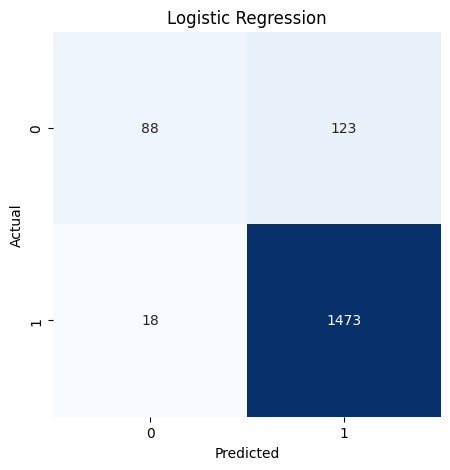

In [29]:
train_score = model.score(X_train_tfidf, y_train)
test_score = model.score(X_test_tfidf, y_test)

y_pred_train = model.predict(X_train_tfidf)
y_pred_test = model.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

print("\nClassification Report for Training Data:")
print(classification_report(y_train, y_pred_train))

print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred_test))

lr_cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 5))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## Support Vector Classifiers Model

SVC Training Accuracy: 0.9635615633264767
SVC Testing Accuracy: 0.9159811985898942

Classification Report for SVC Training Data:
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       860
           1       0.96      1.00      0.98      5946

    accuracy                           0.96      6806
   macro avg       0.96      0.87      0.91      6806
weighted avg       0.96      0.96      0.96      6806


Classification Report for SVC Testing Data:
              precision    recall  f1-score   support

           0       0.79      0.44      0.56       211
           1       0.92      0.98      0.95      1491

    accuracy                           0.92      1702
   macro avg       0.86      0.71      0.76      1702
weighted avg       0.91      0.92      0.91      1702



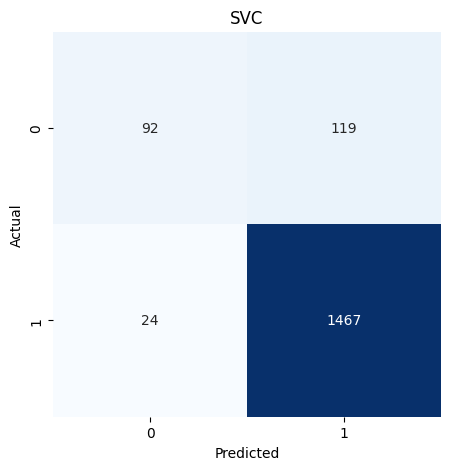

In [30]:
svc_model = SVC()
svc_model.fit(X_train_tfidf, y_train)

svc_train_score = svc_model.score(X_train_tfidf, y_train)
svc_test_score = svc_model.score(X_test_tfidf, y_test)

y_pred_train_svc = svc_model.predict(X_train_tfidf)
y_pred_test_svc = svc_model.predict(X_test_tfidf)

svc_train_accuracy = accuracy_score(y_train, y_pred_train_svc)
svc_test_accuracy = accuracy_score(y_test, y_pred_test_svc)

print("SVC Training Accuracy:", svc_train_accuracy)
print("SVC Testing Accuracy:", svc_test_accuracy)

print("\nClassification Report for SVC Training Data:")
print(classification_report(y_train, y_pred_train_svc))

print("\nClassification Report for SVC Testing Data:")
print(classification_report(y_test, y_pred_test_svc))

# Compute confusion matrix for SVC
svc_cm = confusion_matrix(y_test, y_pred_test_svc)
plt.figure(figsize=(5, 5))
sns.heatmap(svc_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## Random Forest Classifier Model


Random Forest Training Accuracy: 0.989127240669997
Random Forest Testing Accuracy: 0.9165687426556992

Classification Report for Random Forest Training Data:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       860
           1       0.99      1.00      0.99      5946

    accuracy                           0.99      6806
   macro avg       0.99      0.96      0.97      6806
weighted avg       0.99      0.99      0.99      6806


Classification Report for Random Forest Testing Data:
              precision    recall  f1-score   support

           0       0.79      0.44      0.57       211
           1       0.93      0.98      0.95      1491

    accuracy                           0.92      1702
   macro avg       0.86      0.71      0.76      1702
weighted avg       0.91      0.92      0.91      1702



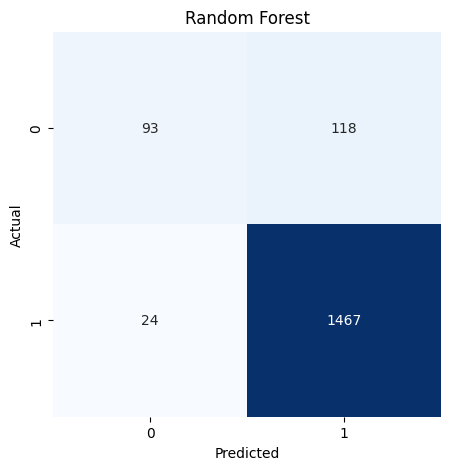

In [31]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)


rf_train_score = rf_model.score(X_train_tfidf, y_train)
rf_test_score = rf_model.score(X_test_tfidf, y_test)

y_pred_train_rf = rf_model.predict(X_train_tfidf)
y_pred_test_rf = rf_model.predict(X_test_tfidf)

rf_train_accuracy = accuracy_score(y_train, y_pred_train_rf)
rf_test_accuracy = accuracy_score(y_test, y_pred_test_rf)

print("\nRandom Forest Training Accuracy:", rf_train_accuracy)
print("Random Forest Testing Accuracy:", rf_test_accuracy)

print("\nClassification Report for Random Forest Training Data:")
print(classification_report(y_train, y_pred_train_rf))

print("\nClassification Report for Random Forest Testing Data:")
print(classification_report(y_test, y_pred_test_rf))

# Compute confusion matrix for Random Forest
rf_cm = confusion_matrix(y_test, y_pred_test_rf)
plt.figure(figsize=(5, 5))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
